# Data Exploration
- This notebook performs exploratory data analysis on the dataset.
- To expand on the analysis, attach this notebook to a cluster with runtime version **13.0.x-cpu-ml-scala2.12**, and rerun it.
- Explore completed trials in the [MLflow experiment](#mlflow/experiments/3922847372101687).

In [0]:
import os
import uuid
import pandas as pd
import shutil
import databricks.automl_runtime
import pyspark.pandas as ps

import mlflow

ps.options.plotting.backend = "matplotlib"

# Download input data from mlflow into a pyspark.pandas DataFrame
# create temp directory to download data
exp_temp_dir = os.path.join("/dbfs/tmp", str(uuid.uuid4())[:8])
os.makedirs(exp_temp_dir)

# download the artifact and read it
exp_data_path = mlflow.artifacts.download_artifacts(run_id="5c563a0d265344f58fddab54c2080272", artifact_path="data", dst_path=exp_temp_dir)
exp_file_path = os.path.join(exp_data_path, "training_data")
exp_file_path  = "file://" + exp_file_path

df = ps.from_pandas(pd.read_parquet(exp_file_path)).spark.cache()

target_col = "num_sold"
time_col = "date"

### Aggregate data

In [0]:
group_cols = [time_col]

df_aggregated = df \
  .groupby(group_cols) \
  .agg(num_sold=(target_col, "avg")) \
  .reset_index()

## Time column Analysis

Show the time range for the time series

In [0]:
df_time_range = df_aggregated[time_col].agg(["min", "max"])
df_time_range

min    2019-04-07
max    2021-12-31
Name: date, dtype: object

## Target Value Analysis

Time series target value status

In [0]:
target_stats_df = df_aggregated[target_col].describe()
display(target_stats_df.reset_index())

index,num_sold
count,1000.0
mean,163.64418666666668
std,21.64305960427475
min,105.89333333333333
25%,151.06666666666666
50%,162.89333333333335
75%,175.16
max,274.08


Check the number of missing values in the target column.

In [0]:
def num_nulls(x):
  num_nulls = x.isnull().sum()
  return pd.Series(num_nulls)

null_stats_df = df_aggregated.apply(num_nulls)[target_col]
null_stats_df

0    0
Name: num_sold, dtype: int64

## Visualize the Data

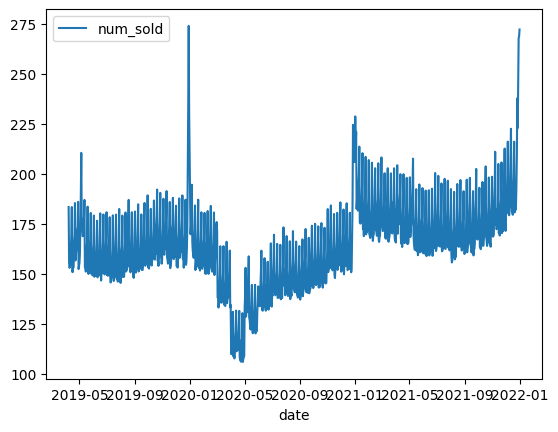

In [0]:
df_sub = df_aggregated

df_sub = df_sub.filter(items=[time_col, target_col])
df_sub.set_index(time_col, inplace=True)
df_sub[target_col] = df_sub[target_col].astype("float")

fig = df_sub.plot()

In [0]:
# delete the temp data
shutil.rmtree(exp_temp_dir)